<a href="https://colab.research.google.com/github/minerva-spring-pds/Group-Project-Sprint-3/blob/master/Part4/lime_explanation_cactus_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
## connecting notebook to google drive
# click on the URL, give permissions and copy and paste the authorisation code to connect
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


# Local Interpretable Model-Agnostic Explanations (LIME) for Cactus Classification Model (Soren)
This code is explained in more detail and with more context in my article ["Model interpretation with LIME and concluding remarks"](https://medium.com/@soren.gran/part-4-model-interpretation-with-lime-and-concluding-remarks-fdcfa6dae667).

This implementation of LIME was taken largely from [Marco Tulio Correia Ribeiro's tutorial](https://github.com/marcotcr/lime/blob/master/doc/notebooks/Tutorial%20-%20Image%20Classification%20Keras.ipynb?fbclid=IwAR2zmS6xUc9zbd2esk3pGc1dWxR8adF6IEXjx-q6Yq-CJ9KGPHO_0Y7XBmE).

This LIME implementation is performed on a convolutional neural network model for cactus classification using [Kaggle's cactus dataset](https://www.kaggle.com/c/aerial-cactus-identification/data).

## Importing Libraries

In [21]:
!pip install lime

from keras.applications import inception_v3 as inc_net
from keras.preprocessing import image
from lime import lime_image
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob
import imageio
import os
import PIL
import cv2

%tensorflow_version 1.x

import keras
import tensorflow as tf
from keras.layers import Input, Dense, Conv2D, UpSampling2D, MaxPool2D, Flatten, BatchNormalization
from keras.models import Model, load_model

TensorFlow is already loaded. Please restart the runtime to change versions.


## Importing Model

In [0]:
# make sure to place the folder in the main section of your google drive to connect to this folder
os.chdir('/gdrive/My Drive/Cactus')

In [0]:
train_label = pd.read_csv('train.csv')
sample_submission = pd.read_csv('sample_submission.csv')

## Preparing our model
We are working with an autoencoder-inspired convolutional neural network. For more information on this model, please check out [Part 3](https://medium.com/@darya.dyachkova/part-3-model-selection-and-implementation-with-convolutional-neural-networks-cnn-294a581b01ea).  
We will build the model but we do not need to train it. Instead, we will import our previous weights, which we got from training earlier, into our model.  
The next two cells build the model. The first cell contains the fully connected layer and the second cell contains the rest of the CNN.

In [0]:
# Fully Connected Layer
def fc(enco):
    flat = Flatten()(enco)
    den = Dense(128, activation='relu')(flat) 
    out = Dense(2, activation='softmax')(den)
    return out

In [0]:
# Convolutional Neural Network
def encoder_2(input_img_2):
  encoded_2 = Conv2D(filters = 256, kernel_size = (3, 3), activation='relu', padding='same')(input_img_2)
  encoded_2 = Conv2D(filters = 256, kernel_size = (3, 3), activation='relu', padding='same')(encoded_2)
  encoded_2 = MaxPool2D(pool_size = (2, 2), padding='same', strides=2)(encoded_2)
  print(encoded_2.shape)

  # Conv2 #
  encoded_2 = Conv2D(filters = 128, kernel_size = (3, 3), activation='relu', padding='same')(encoded_2)
  encoded_2 = Conv2D(filters = 128, kernel_size = (3, 3), activation='relu', padding='same')(encoded_2)
  encoded_2 = MaxPool2D(pool_size = (2, 2), padding='same', strides=2)(encoded_2)
  print(encoded_2.shape)

  # Conv3 #
  encoded_2 = Conv2D(filters = 64, kernel_size = (3, 3), activation='relu', padding='same')(encoded_2)
  encoded_2 = Conv2D(filters = 64, kernel_size = (3, 3), activation='relu', padding='same')(encoded_2)
  encoded_2 = MaxPool2D(pool_size = (2, 2), padding='same', strides=2)(encoded_2)
  print(encoded_2.shape)
  return encoded_2

In [27]:
# Putting the model together
input_img = Input(shape = (32, 32, 3))
encode = encoder_2(input_img)
full_model = Model(input_img,fc(encode))

(None, 16, 16, 256)
(None, 8, 8, 128)
(None, 4, 4, 64)


## Next we load our model weights
Training a convolutional neural network takes a long time. We have already trained our model (see [Part 3](https://medium.com/@darya.dyachkova/part-3-model-selection-and-implementation-with-convolutional-neural-networks-cnn-294a581b01ea)).

In [0]:
full_model.load_weights('classification_model.h5')

In [29]:
full_model.weights

[<tf.Variable 'conv2d_7/kernel:0' shape=(3, 3, 3, 256) dtype=float32, numpy=
 array([[[[ 1.51741374e-02, -2.08636168e-02,  4.06656712e-02, ...,
           -4.44191098e-02, -3.01180296e-02,  2.70537902e-02],
          [-4.15976904e-02, -2.77353786e-02,  7.05368444e-02, ...,
            1.60697922e-02,  3.40429954e-02, -3.10876174e-03],
          [ 3.53286089e-03, -5.51937111e-02,  5.62381931e-02, ...,
           -1.03718163e-02,  2.82081980e-02,  6.99565336e-02]],
 
         [[ 4.20638509e-02,  2.38795672e-02, -3.81743684e-02, ...,
            3.86105385e-03, -3.91250812e-02, -1.29590631e-02],
          [-5.11381812e-02,  9.51097384e-02,  5.01162522e-02, ...,
            2.72790045e-02, -2.76702754e-02,  2.77454164e-02],
          [-9.01124068e-03, -1.46734212e-02,  3.65227573e-02, ...,
            1.20612234e-02, -2.92597264e-02,  9.99068320e-02]],
 
         [[-6.15630485e-03,  4.04334664e-02,  2.15416495e-02, ...,
           -3.47921699e-02, -8.03890731e-03, -1.40605038e-02],
       

## Preprocessing data for LIME explanation
Our CNN model is ready to go. Let's move on to preparing for LIME explanation.  
The function in the next cell takes image data as input (in our case, .jpg) and returns a flattened data format.  
In theory, this function could take a list of images and return the images as a list of arrays. For our demonstration purposes, however, we will input images one-by-one.  
This function comes from [Marco Tulio Correia Ribeiro's tutorial](https://github.com/marcotcr/lime/blob/master/doc/notebooks/Tutorial%20-%20Image%20Classification%20Keras.ipynb?fbclid=IwAR2zmS6xUc9zbd2esk3pGc1dWxR8adF6IEXjx-q6Yq-CJ9KGPHO_0Y7XBmE).


In [0]:
def transform_img_fn(path_list):
    out = []
    for img_path in path_list:
        img = image.load_img(img_path, target_size=(32, 32))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = inc_net.preprocess_input(x)
        out.append(x)
    return np.vstack(out)

[[0.45229775 0.5477022 ]]


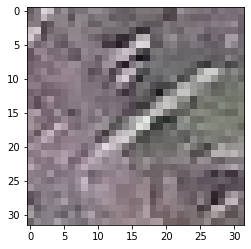

In [31]:
# Let's look at an example image.
images = transform_img_fn(['train/fff059ecc91b30be5745e8b81111dc7b.jpg'])

plt.imshow(images[0] / 2 + 0.5)
preds = full_model.predict(images)
print(preds)

## What did we just see?
1. We saw the image. It looks extremely blurry because earlier we wrote ```Input(shape = (32, 32, 3))```, designating the images as being 32 pixels by 32 pixels. Although this makes the images blurry, it reduces the time needed to analyze each image because the amount of data per image has been reduced drastically.
2. From ```print(preds)```, we received the output ```[[0.45229775 0.5477022 ]]```. These numbers represent the model's decision (they are unlabeled because we only have two classifications - 0 (not a cactus-of-interest) and 1 (cactus-of-interest). The first number, ```0.45229775```, is essentially the model's predicted probability of the image in question being 0, while the second output ```0.5477022``` is the predicted probability of the image being 1 (a cactus-of-interest).

## LIME explanation
In the following cells, we prepare the LIME explainer using [Marco Tulio Correia Ribeiro's LIME package for Python](https://github.com/marcotcr/lime).

In [0]:
explainer = lime_image.LimeImageExplainer()

In [33]:
explanation = explainer.explain_instance(images[0], full_model.predict, top_labels=5, hide_color=0, num_samples=1000)

In [0]:
from skimage.segmentation import mark_boundaries

# Displaying the LIME explanation
The next three cells display the LIME explanation. They are presenting the same data in three different ways by manipulating two arguments of the ```LimeImageExplainer()``` function: ```positive_only``` and ```hide_rest```.  
By setting ```positive_only = True``` and ```hide_rest = True```, the explainer shows us only the parts of the image that contributed to the classifier's most likely prediction. If the classifier has predicted that an image contains a cactus, this  setting will display only the parts of the image that contributed to that prediction.  
By setting ```positive_only = True``` and ```hide_rest = False```, the explainer shows the entire image but shows the distinction between sections of the image that contributed to each label. Using this setting by itself can be confusing because although it shows different segments of the image (called superpixels), it does not indicate which superpixels contributed to which label.  
By setting ```positive_only = False``` and ```hide_rest = False```, the explainer shows us the entire image, like in the previous setting, but indicates which superpixels correspond to which labels. Superpixels corresponding to the most likely superpixel are in green.

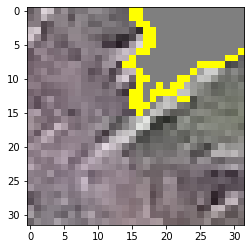

In [35]:
temp, mask = explanation.get_image_and_mask(1, positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

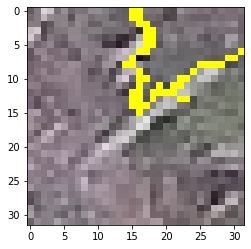

In [36]:
temp, mask = explanation.get_image_and_mask(1, positive_only=True, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

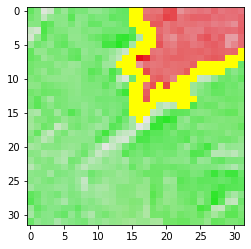

In [37]:
temp, mask = explanation.get_image_and_mask(1, positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

The last three cells displayed the same data but in different ways.  

Now let's look at explanations of three other images. Doing so will give us a better idea of what exactly the classifier is looking for when it analyzes images.  
We will do the same preprocessing to prepare the image for LIME explanation and then doing the first and third displays from before. We will skip the second display because it is basically the less useful combination of the first and third display methods.  
These images were chosen randomly from our library.

## Image 1

[[0.45894948 0.54105055]]


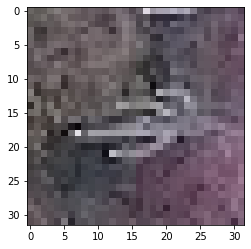

In [38]:
images = transform_img_fn(['train/ffd686dcbe047a863de4d250d9b7687a.jpg'])

plt.imshow(images[0] / 2 + 0.5)
preds = full_model.predict(images)
print(preds)

explanation = explainer.explain_instance(images[0], full_model.predict, top_labels=5, hide_color=0, num_samples=1000)

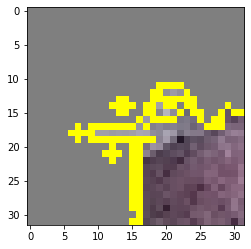

In [39]:
temp, mask = explanation.get_image_and_mask(1, positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

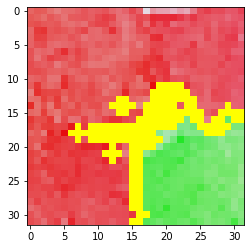

In [40]:
temp, mask = explanation.get_image_and_mask(1, positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

## Image 2

[[0.4622626  0.53773737]]


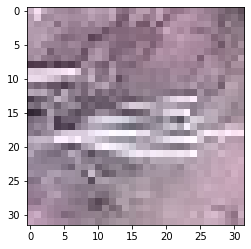

In [41]:
images = transform_img_fn(['train/ff78f7f0d19b99a8ffd98b63bf8a6e36.jpg'])

plt.imshow(images[0] / 2 + 0.5)
preds = full_model.predict(images)
print(preds)

explanation = explainer.explain_instance(images[0], full_model.predict, top_labels=5, hide_color=0, num_samples=1000)

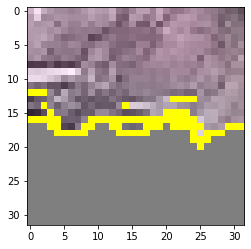

In [42]:
temp, mask = explanation.get_image_and_mask(1, positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

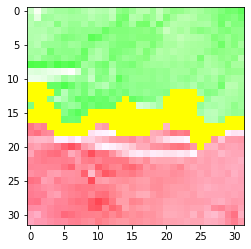

In [43]:
temp, mask = explanation.get_image_and_mask(1, positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

## Image 3

[[0.45581782 0.5441822 ]]


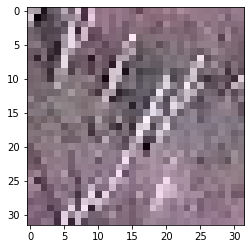

In [44]:
images = transform_img_fn(['train/fdba1461a2b3c9b6a68c84fc5252c4b9.jpg'])

plt.imshow(images[0] / 2 + 0.5)
preds = full_model.predict(images)
print(preds)

explanation = explainer.explain_instance(images[0], full_model.predict, top_labels=5, hide_color=0, num_samples=1000)

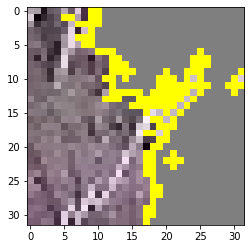

In [45]:
temp, mask = explanation.get_image_and_mask(1, positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))